# Text Classification Procedure and Results

The following notebook details the machine learning procedure, experiments, and results for the MDS 2019 Capstone project. The purpose of this notebook is to illustrate the details of the code in a digestable format.

This analysis notebook best accompanies the [MDS Final Report]() which introduces the problem and more formally describes the methodology and results. To learn how to implement the data on future WES comments see the [WES Classification USAGE]() notebook.

In [2]:
# Change working directory to be project root
import os
os.chdir("..")
os.getcwd()

'/Users/aaronquinton/Documents/UBC-MDS/Capstone/BCstats/DSCI_591_capstone-BCStats'

In [1]:
import sys

In [ ]:
sys.path.insert()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import time

# Custom functions for preprocessing, data preparation, and evaluation
from src.data.preprocessing_text import (
    clean_text, clean_numbers, replace_typical_misspell, remove_stopwords,
    preprocess_for_embed, preprocess_for_bow, build_vocab, check_coverage
)

from src.features.avg_embeddings import (
     get_average_embeddings
)

from src.models.eval_metrics import theme_results, investigate_results

# Functions for preprocessing, data preparation, and evaluation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

# Training Word embeddings and pre-trained embeddings
import gensim
from gensim.models import Word2Vec, KeyedVectors

# Keras Deep learning functions for LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPooling1D, Conv1D, GlobalAveragePooling1D
from keras.layers import GRU, concatenate
from keras.models import Sequential
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

# Classification alogrithms
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression


/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## <span style = "color:Darkblue"> Read in Data and Embeddings </span>

In [3]:
# Input Filepaths
# Data Files
fname_rawdata2018 = "data/interim/train_2018-qualitative-data.csv"
fname_quant = "data/processed/tidy_quant_questions.csv"
fname_legend = "references/data-dictionaries/survey_mc_legend.csv"

# Pre-trained Embeddings
fname_fasttext_crawl = "./references/pretrained_embeddings.nosync/fasttext/" \
                       "crawl-300d-2M.vec"
fname_fasttext_wiki = "./references/pretrained_embeddings.nosync/fasttext/" \
                      "wiki-news-300d-1M.vec"
fname_w2v_googlenews = "./references/pretrained_embeddings.nosync/w2v/" \
                       "GoogleNews-vectors-negative300.bin"
fname_glove_twitter = "./references/pretrained_embeddings.nosync/glove/" \
                      "glove.twitter.27B.200d.w2v.txt"
fname_glove_wiki = "./references/pretrained_embeddings.nosync/glove/" \
                      "glove.6B.300d.w2v.txt"
fname_glove_crawl = "./references/pretrained_embeddings.nosync/glove/" \
                      "glove.840B.300d.w2v.txt"

In [4]:
# Read in raw data
df = pd.read_csv(fname_rawdata2018)

In [5]:
t_start = time.time()

# Read in pre-trained embeddings
w2v_google_news = KeyedVectors.load_word2vec_format(fname_w2v_googlenews,
                                                    binary=True)
fasttext_crawl = KeyedVectors.load_word2vec_format(fname_fasttext_crawl,
                                                   unicode_errors='ignore')
fasttext_wiki = KeyedVectors.load_word2vec_format(fname_fasttext_wiki,
                                                  unicode_errors='ignore')
glove_twitter = KeyedVectors.load_word2vec_format(fname_glove_twitter,
                                                  unicode_errors='ignore')
glove_wiki = KeyedVectors.load_word2vec_format(fname_glove_wiki,
                                               unicode_errors='ignore')
glove_crawl = KeyedVectors.load_word2vec_format(fname_glove_crawl,
                                                unicode_errors='ignore')

t_end = time.time()
print("Elapsed time to load embeddings: %.1f s" % (t_end - t_start))

Elapsed time to load embeddings: 3242.8 s


## <span style = "color:Darkblue"> Preprocessing and Data Preperation</span>

### Preparing Comment data

In [6]:
df_userid = df[['_telkey', '2018 Comment']]
df_userid = df_userid.rename(columns = {'_telkey':'USERID'})

df = df[['2018 Comment']].join(df.loc[:,'CPD':'OTH'])
df = df.rename(columns = {'2018 Comment' : 'comment'})

Y = np.array(df.loc[:,"CPD":"OTH"])

themes = df.loc[:,'CPD':'OTH'].columns.tolist()

# Split the data
df_X_train, df_X_valid, Y_train, Y_valid = train_test_split(
        df.comment, Y, test_size=0.25, random_state=2019)

In [7]:
print(df_X_train.shape)
print(Y_train.shape)

(9958,)
(9958, 12)


### Prepare Quantitative Data

In [298]:
df_quant = pd.read_csv(fname_quant).query("survey_year == 2018")
df_legend = pd.read_csv(fname_legend)

In [340]:
df_quant_train = df_userid.loc[df_X_train.index] \
                          .merge(df_quant, how='left', on='USERID')

df_quant_valid = df_userid.loc[df_X_valid.index] \
                          .merge(df_quant, how='left', on='USERID')

In [1051]:
X_train_quant = np.array(df_quant_train.iloc[:,3:20])
X_valid_quant = np.array(df_quant_valid.iloc[:,3:20])

In [1055]:
# Fill missing values with the mean response for that column
for i in range(X_train_quant.shape[1]):
    mean_replace = np.nanmean(X_train_quant, axis = 0)[i]
    X_train_quant[:,i][np.isnan(X_train_quant[:,i])] = mean_replace
    X_valid_quant[:,i][np.isnan(X_valid_quant[:,i])] = mean_replace


In [1058]:
print(X_train_quant.shape)
print(X_valid_quant.shape)

(9958, 17)
(3320, 17)


### Train Word Vectors

In [8]:
comments = preprocess_for_embed(df.comment, 'w2v_base_model')

w2v_base_model = Word2Vec(comments, 
                     size=300, 
                     window=5, 
                     min_count=1,
                     sg=1, 
                     negative=4)        

In [62]:
# Dictionary of pretrained embeddings
embeddings = {'w2v_base_model': w2v_base_model,
              'w2v_google_news': w2v_google_news, 
              'fasttext_crawl': fasttext_crawl,
              'fasttext_wiki': fasttext_wiki,
              'glove_twitter': glove_twitter,
              'glove_wiki': glove_wiki,
              'glove_crawl': glove_crawl}

### Word Embedding Vocab Coverage

In [10]:
# Check coverage of vocab words in embedding
oov = {}
vocab_coverage = []
text_coverage = []

for embedding in embeddings.keys():
    
    comments = preprocess_for_embed(df.comment, embedding)
    vocab = build_vocab(comments)
        
    a, b, oov[embedding] = check_coverage(vocab, embeddings[embedding])
    
    vocab_coverage.append(a)
    text_coverage.append(b)

pd.DataFrame({'embedding': list(embeddings.keys()),
              'vocab_coverage': vocab_coverage, 
              'text_coverage': text_coverage})

100%|██████████| 17500/17500 [00:10<00:00, 1624.85it/s]


,embedding,vocab_coverage,text_coverage
0,w2v_base_model,1.000000,1.000000
1,w2v_google_news,0.939870,0.996661
2,fasttext_crawl,0.953943,0.997412
3,fasttext_wiki,0.938514,0.996345
4,glove_twitter,0.887954,0.990666
5,glove_wiki,0.913479,0.994892
6,glove_crawl,0.953543,0.997421


In [11]:
# Take a look at the out of vocab words for each embedding
for i in oov.keys():
    print(i)
    print(oov[i][:5])

w2v_base_model
[]
w2v_google_news
[('CYMH', 54), ('FLNRORD', 35), ('GCPE', 33), ('CSNR', 32), ('BCWS', 23)]
fasttext_crawl
[('CYMH', 54), ('BCTS', 37), ('FLNRORD', 35), ('GCPE', 33), ('CSNR', 32)]
fasttext_wiki
[('MCFD', 128), ('CYMH', 54), ('BCTS', 37), ('FLNRORD', 35), ('GCPE', 33)]
glove_twitter
[('2', 402), ('1', 302), ('3', 236), ('4', 171), ('5', 151)]
glove_wiki
[('####', 181), ('mcfd', 131), ('cymh', 54), ('#####', 49), ('bcts', 37)]
glove_crawl
[('CYMH', 54), ('FLNRORD', 35), ('GCPE', 33), ('CSNR', 32), ('STIIP', 20)]


## <span style = "color:Darkblue"> Feature Engineering </span>

### Bag of Words


In [245]:
# Use Count Vectorizer to build bag of word arrays to train on
vectorizer = CountVectorizer(stop_words= 'english',
                             ngram_range=(1,5), 
                             min_df=2)   

X_train_bow = vectorizer.fit_transform(preprocess_for_bow(df_X_train))
X_valid_bow = vectorizer.transform(preprocess_for_bow(df_X_valid))

In [246]:
print(X_train_bow.shape)
print(X_valid_bow.shape)

(9958, 31422)
(3320, 31422)


### Get Average Word Vectors per Comment

In [247]:
X_train_avg_wv = {}
X_valid_avg_wv = {}

for embedding in embeddings.keys():
    
    # Adjust features based on twitter embeddings 
    if embedding == 'glove_twitter':
        n_features = 200
    else:
        n_features = 300
    
    # Preprocess comment data
    comments_train = preprocess_for_embed(df_X_train, embedding)
    comments_valid = preprocess_for_embed(df_X_valid, embedding)
    
    # Get average embeddings for each comment
    # train
    X_train_avg_wv[embedding] = np.array(
        [get_average_embeddings(comment, embeddings[embedding], n_features)
         for comment in comments_train])
    
    # valid
    X_valid_avg_wv[embedding] = np.array(
        [get_average_embeddings(comment, embeddings[embedding], n_features)
         for comment in comments_valid])

In [248]:
print(X_valid_avg_wv['w2v_base_model'].shape)
print(X_valid_avg_wv['glove_twitter'].shape)

(3320, 300)
(3320, 200)


### Build Embedding Matrices and Encode text data

In [63]:
# Build Embedding Matrices and prepare data for deep 
# learning Models
max_words = 12000
maxlen = 700

# dictionaries for each embedding
embedding_matrix = {}
tokenizer = {}
X_train_embed = {}
X_valid_embed = {}

for embedding in embeddings.keys():

    # Preprocess text data based on embedding
    X_train = np.array(preprocess_for_embed(df_X_train,
                                            embedding,
                                            split = False))
    
    X_valid = np.array(preprocess_for_embed(df_X_valid,
                                            embedding,
                                            split = False))
    
    # Tokenize and pad numbers for LSTM Model
    tokenizer[embedding] = Tokenizer(num_words=max_words)
    tokenizer[embedding].fit_on_texts(X_train)
    
    tokenized_train = tokenizer[embedding].texts_to_sequences(X_train)
    tokenized_test = tokenizer[embedding].texts_to_sequences(X_valid)

    X_train_embed[embedding] = pad_sequences(tokenized_train, maxlen=maxlen)
    X_valid_embed[embedding] = pad_sequences(tokenized_test, maxlen=maxlen)
    
    
    # Build Embedding Matrices
    if embedding == 'glove_twitter':
        embed_size = 200
    else:
        embed_size = 300

    word_index = tokenizer[embedding].word_index
    
    num_words = min(max_words, len(word_index) + 1)
    embedding_matrix[embedding] = np.zeros((num_words, embed_size),
                                           dtype='float32')

    for word, i in word_index.items():

        if i >= max_words:
            continue

        try:
            embedding_vector = embeddings[embedding][word]

            if embedding_vector is not None:
                embedding_matrix[embedding][i] = embedding_vector
        except:
            continue

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


## <span style = "color:Darkblue"> Classification Models </span>
### Baseline Classifier - BOW | Linear SVC 

#### Optimize Hyper Parameters for BOW | Linear SVC

In [829]:
# C = (5.0**np.arange(-1,4)/10).tolist()
# C.append(1)

# tol = (5.0**np.arange(-3,2)/100).tolist()
# tol.append(0.0001)

# print('C:', C)
# print('tol:', tol)

C: [0.02, 0.1, 0.5, 2.5, 12.5, 1]
tol: [8e-05, 0.0004, 0.002, 0.01, 0.05, 0.0001]


In [830]:
# t_start = time.time()
# print("Grid Search for BOW | Linear SVC")

# parameters = [
#     {
#         'classifier':[LinearSVC(max_iter=2000)],
#         'classifier__tol': tol,
#         'classifier__C': C,    
#     }
# ]

# clf1 = GridSearchCV(BinaryRelevance(), parameters, scoring = 'accuracy', cv = 2)
# clf1.fit(X_train_bow, Y_train)

# t_end_train = time.time()

# print(clf1.best_params_, clf1.best_score_)
# # Calculate and print elapsed time
# t_end = time.time()
# print("Elapsed Training time: %.1f s" % (t_end_train - t_start),
#       "\nElapsed Predict time: %.1f s" % (t_end - t_end_train))

Grid Search for BOW | Linear SVC
{'classifier': LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=2000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.05,
     verbose=0), 'classifier__C': 0.5, 'classifier__tol': 0.05} 0.4243824061056437
Elapsed Training time: 5454.6 s 
Elapsed Predict time: 0.1 s


#### Final BOW | Linear SVC Model

In [837]:
t_start = time.time()
print("Training Bag of words Model with Linear SVC")

model_bow = BinaryRelevance(
    classifier = LinearSVC(C = 0.5, tol = 0.2)
)

model_bow.fit(X_train_bow, Y_train)
t_end_train = time.time()

Y_pred_bow = model_bow.predict(X_valid_bow).toarray()

# Calculate and print elapsed time
t_end = time.time()
print("Elapsed Training time: %.1f s" % (t_end_train - t_start),
      "\nElapsed Predict time: %.1f s" % (t_end - t_end_train))

Training Bag of words Model with Linear SVC
Elapsed Training time: 71.4 s 
Elapsed Predict time: 13.1 s


In [1091]:
results_bow = pd.DataFrame({'Model': 'BOW | LinearSVC',
                            'train_time': [71.4],
                            'predict_time': [13.1],
                            'overall_accuracy': [metrics.accuracy_score(Y_valid, 
                                                                       Y_pred_bow)]})

In [838]:
theme_results(Y_valid, Y_pred_bow)

Overall Accuracy: 0.4512 
Hamming Loss: 0.0721 
Hamming Loss (pred. zeros): 0.1191


,Label,Y_proportion,Pred_proportion,Error,Dummy_Diff,Accuarcy,Precision,Recall
0,CPD,0.127410,0.112048,0.073193,0.054217,0.926807,0.741935,0.652482
1,CB,0.184639,0.174096,0.043072,0.141566,0.956928,0.906574,0.854812
2,EWC,0.084337,0.056325,0.067771,0.016566,0.932229,0.647059,0.432143
3,Exec,0.103012,0.089157,0.081325,0.021687,0.918675,0.621622,0.538012
4,FWE,0.062048,0.054217,0.025904,0.036145,0.974096,0.833333,0.728155
5,SP,0.096386,0.082229,0.065964,0.030422,0.934036,0.684982,0.584375
6,RE,0.085542,0.062952,0.075602,0.009940,0.924398,0.578947,0.426056
7,Sup,0.127711,0.111145,0.105723,0.021988,0.894277,0.598916,0.521226
8,SW,0.165964,0.134639,0.115060,0.050904,0.884940,0.689038,0.558984
9,TEPE,0.228614,0.211145,0.071687,0.156928,0.928313,0.871612,0.805007


In [839]:
print("Shape of Y_pred:",Y_pred_bow.shape)
print("Zeros predicted:",Y_pred_bow[Y_pred_bow.sum(axis = 1) == 0,:].shape)

Shape of Y_pred: (3320, 12)
Zeros predicted: (466, 12)


### Average Word Vectors | LogReg SVC

#### Optimize Hyperparameters for Avg WV | LogReg

In [ ]:
# C = (5.0**np.arange(-1,4)/10).tolist()
# C.append(1)

# tol = (5.0**np.arange(-3,2)/100).tolist()
# tol.append(0.0001)

# print('C:', C)
# print('tol:', tol)

In [ ]:
# for embedding in embeddings.keys():
    
#     print("Grid Search on: ", embedding)
#     t_start = time.time()

#     parameters = [
#         {
#             'classifier':[LogisticRegression(solver = 'lbfgs', max_iter=500)],
#             'classifier__tol': tol,
#             'classifier__C': C,
        
#         }
#     ]

#     clf2 = GridSearchCV(BinaryRelevance(), parameters, scoring = 'accuracy', cv = 2)
#     clf2.fit(X_train_avg_wv[embedding], Y_train)

#     t_end_train = time.time()

#     print(clf2.best_params_, clf2.best_score_)
#     # Calculate and print elapsed time
#     t_end = time.time()
#     print("Elapsed Training time: %.1f s" % (t_end_train - t_start),
#       "\nElapsed Predict time: %.1f s" % (t_end - t_end_train))


#### Final Avg WV | LogReg Model

In [845]:
Y_pred_avg_wv = {}
model_avg_wv = {}
train_time = []
predict_time = []
accuarcies = []

for embedding in embeddings.keys():
    t_start = time.time()

    clf = BinaryRelevance(
        classifier = LogisticRegression(solver = 'lbfgs', max_iter=500, C = 7.5,
                                        tol = 0.05)
    )

    clf.fit(X_train_avg_wv[embedding], Y_train)
    t_end_train = time.time()

    Y_pred_avg_wv[embedding] = clf.predict_proba(X_valid_avg_wv[embedding]) \
                                  .toarray()
    model_avg_wv[embedding] = clf
    
    # Calculate elapsed time
    t_end = time.time()
    train_time.append(t_end_train - t_start)
    predict_time.append(t_end - t_end_train)
    
    accuarcies.append(metrics.accuracy_score(Y_valid,
                                             np.round(Y_pred_avg_wv[embedding])))

results_avg_wv = pd.DataFrame({'embedding': list(embeddings.keys()),
                               'train_time': train_time,
                               'predict_time': predict_time,
                               'overall_accuracy': accuarcies})

results_avg_wv

,embedding,train_time,predict_time,overall_accuracy
0,w2v_base_model,6.191823,0.065399,0.360843
1,w2v_google_news,4.602850,0.222380,0.406325
2,fasttext_crawl,5.089044,0.190777,0.421687
3,fasttext_wiki,4.718872,0.276683,0.398795
4,glove_twitter,7.091348,0.339133,0.354217
5,glove_wiki,9.596981,0.359630,0.406024
6,glove_crawl,8.432222,0.280792,0.409337


### Neural Net Models

In [66]:
model_conv1d = {}
Y_pred_conv1d = {}

{}

### Conv1d Model

In [113]:
max_features = 12000
maxlen = 700
batch_size = 128
embed_size = 300
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 10


model = Sequential()

model.add(Embedding(max_features,
                    embed_size,
                    input_length = maxlen))
model.add(Dropout(0.2))

model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))

model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Dense(12))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train_embed['glove_crawl'],
          Y_train,
          batch_size=batch_size,
          epochs=epochs, 
          validation_split=0.15)

model_conv1d['base'] = model

Y_pred_conv1d['base'] = model.predict(X_valid_embed['glove_crawl'])

Train on 8464 samples, validate on 1494 samples
Epoch 1/10
8464/8464 [==============================] - 153s 18ms/step - loss: 0.3937 - acc: 0.8712 - val_loss: 0.3376 - val_acc: 0.8881
Epoch 2/10
8464/8464 [==============================] - 145s 17ms/step - loss: 0.2891 - acc: 0.8991 - val_loss: 0.2400 - val_acc: 0.9156
Epoch 3/10
8464/8464 [==============================] - 137s 16ms/step - loss: 0.2173 - acc: 0.9205 - val_loss: 0.2075 - val_acc: 0.9261
Epoch 4/10
8464/8464 [==============================] - 136s 16ms/step - loss: 0.1770 - acc: 0.9327 - val_loss: 0.1956 - val_acc: 0.9292
Epoch 5/10
8464/8464 [==============================] - 139s 16ms/step - loss: 0.1476 - acc: 0.9442 - val_loss: 0.1837 - val_acc: 0.9318
Epoch 6/10
8464/8464 [==============================] - 134s 16ms/step - loss: 0.1216 - acc: 0.9534 - val_loss: 0.1812 - val_acc: 0.9328
Epoch 7/10
8464/8464 [==============================] - 137s 16ms/step - loss: 0.0984 - acc: 0.9634 - val_loss: 0.1851 - val_acc: 

In [96]:
model_conv1d

{'w2v_base_model': <keras.engine.sequential.Sequential at 0x1db127e710>,
 'w2v_google_news': <keras.engine.sequential.Sequential at 0x1db11f3198>,
 'fasttext_crawl': <keras.engine.sequential.Sequential at 0x1db24d2588>,
 'fasttext_wiki': <keras.engine.sequential.Sequential at 0x1db161f048>,
 'glove_twitter': <keras.engine.sequential.Sequential at 0x1db1773f98>,
 'glove_wiki': <keras.engine.sequential.Sequential at 0x1db17734a8>,
 'glove_crawl': <keras.engine.sequential.Sequential at 0x1db1a859e8>}

In [114]:
theme_results(Y_valid, np.round(Y_pred_conv1d['base']))

Overall Accuracy: 0.5054 
Hamming Loss: 0.0666 
Hamming Loss (pred. zeros): 0.1191


,Label,Y_count,Pred_count,Error,Dummy_Diff,Accuarcy,Precision,Recall
0,CPD,423,441,0.067470,0.059940,0.932530,0.725624,0.756501
1,CB,613,587,0.036145,0.148494,0.963855,0.919932,0.880914
2,EWC,280,139,0.061747,0.022590,0.938253,0.769784,0.382143
3,Exec,342,277,0.075000,0.028012,0.925000,0.667870,0.540936
4,FWE,206,173,0.026807,0.035241,0.973193,0.838150,0.703883
5,SP,320,266,0.063855,0.032530,0.936145,0.703008,0.584375
6,RE,284,182,0.066867,0.018675,0.933133,0.670330,0.429577
7,Sup,424,430,0.099398,0.028313,0.900602,0.609302,0.617925
8,SW,551,512,0.105723,0.060241,0.894277,0.695312,0.646098
9,TEPE,759,775,0.066867,0.161747,0.933133,0.846452,0.864295


### Conv1d with pretrained Embeddings

In [68]:
max_features = 12000
maxlen = 700
batch_size = 128
embed_size = 300
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 12
train_time = []
predict_time = []
accuarcies = []

for embedding in embeddings.keys():
    t_start = time.time()
    print("Training Conv1d on the ", embedding)
    
    if embedding == 'glove_twitter':
        embed_size = 200
    else:
        embed_size = 300
    
    # Neural Net Architecture
    model = Sequential()

    model.add(Embedding(max_features, embed_size,
                        weights=[embedding_matrix[embedding]], 
                        trainable=False,
                        input_length = maxlen))
    model.add(Dropout(0.2))

    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=1))

    model.add(GlobalMaxPooling1D())
    model.add(Dense(hidden_dims))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))

    model.add(Dense(12))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Train Model
    model.fit(X_train_embed[embedding],
              Y_train,
              batch_size=batch_size,
              epochs=epochs, 
              validation_split=0.15)
    t_end_train = time.time()
    
    model_conv1d[embedding] = model

    Y_pred_conv1d[embedding] = model.predict(X_valid_embed[embedding])
    
    # Calculate and report results
    t_end = time.time()
    train_time.append(t_end_train - t_start)
    predict_time.append(t_end - t_end_train)
    
    accuarcies.append(metrics.accuracy_score(Y_valid,
                                             np.round(Y_pred_conv1d[embedding])))

Training Conv1d on the  w2v_base_model
Train on 8464 samples, validate on 1494 samples
Epoch 1/12
8464/8464 [==============================] - 107s 13ms/step - loss: 0.3550 - acc: 0.8799 - val_loss: 0.2717 - val_acc: 0.9070
Epoch 2/12
8464/8464 [==============================] - 103s 12ms/step - loss: 0.2582 - acc: 0.9070 - val_loss: 0.2228 - val_acc: 0.9173
Epoch 3/12
8464/8464 [==============================] - 103s 12ms/step - loss: 0.2248 - acc: 0.9159 - val_loss: 0.2080 - val_acc: 0.9231
Epoch 4/12
8464/8464 [==============================] - 102s 12ms/step - loss: 0.2113 - acc: 0.9200 - val_loss: 0.2028 - val_acc: 0.9253
Epoch 5/12
8464/8464 [==============================] - 97s 11ms/step - loss: 0.2020 - acc: 0.9239 - val_loss: 0.1978 - val_acc: 0.9265
Epoch 6/12
8464/8464 [==============================] - 95s 11ms/step - loss: 0.1944 - acc: 0.9258 - val_loss: 0.1910 - val_acc: 0.9284
Epoch 7/12
8464/8464 [==============================] - 94s 11ms/step - loss: 0.1863 - acc: 0

Epoch 10/12
8464/8464 [==============================] - 70s 8ms/step - loss: 0.1343 - acc: 0.9483 - val_loss: 0.1825 - val_acc: 0.9332
Epoch 11/12
8464/8464 [==============================] - 70s 8ms/step - loss: 0.1285 - acc: 0.9509 - val_loss: 0.1843 - val_acc: 0.9353
Epoch 12/12
8464/8464 [==============================] - 70s 8ms/step - loss: 0.1194 - acc: 0.9540 - val_loss: 0.1828 - val_acc: 0.9334
Training Conv1d on the  glove_wiki
Train on 8464 samples, validate on 1494 samples
Epoch 1/12
8464/8464 [==============================] - 94s 11ms/step - loss: 0.3514 - acc: 0.8819 - val_loss: 0.2581 - val_acc: 0.9101
Epoch 2/12
8464/8464 [==============================] - 92s 11ms/step - loss: 0.2393 - acc: 0.9138 - val_loss: 0.2091 - val_acc: 0.9268
Epoch 3/12
8464/8464 [==============================] - 92s 11ms/step - loss: 0.2025 - acc: 0.9250 - val_loss: 0.1922 - val_acc: 0.9299
Epoch 4/12
8464/8464 [==============================] - 91s 11ms/step - loss: 0.1802 - acc: 0.9313 - 

In [73]:
results_conv1d = pd.DataFrame({'embedding': list(embeddings.keys()),
                               'train_time': train_time,
                               'predict_time': predict_time,
                               'overall_accuracy': accuarcies})

results_conv1d

,embedding,train_time,predict_time,overall_accuracy
0,w2v_base_model,4580.003196,46.396283,0.481325
1,w2v_google_news,4564.827096,45.402777,0.507831
2,fasttext_crawl,4477.700824,49.579227,0.517771
3,fasttext_wiki,4582.388079,42.911012,0.499096
4,glove_twitter,3269.476459,33.189079,0.497289
5,glove_wiki,3860.588047,41.263492,0.497892
6,glove_crawl,4357.161348,48.177288,0.513554


### Bidirectional GRU Model with Conv1D

In [69]:
# Build LSTM Model and train and validate
Y_pred_biGRU = {}
model_biGRU = {}
train_time = []
predict_time = []
accuarcies = []

for embedding in embeddings.keys():
    t_start = time.time()
    print("Training BiGRU on the ", embedding)
    
    if embedding == 'glove_twitter':
        embed_size = 200
    else:
        embed_size = 300
    
    # Deep Learning Architecture
    inp = Input(shape=(maxlen, ))
    
    x = Embedding(max_words, embed_size, 
                  weights=[embedding_matrix[embedding]], 
                  trainable=False)(inp)

    x = Bidirectional(GRU(128, return_sequences=True, dropout=0.1,
                          recurrent_dropout=0.1))(x)

    x = Conv1D(64, kernel_size=3, padding="valid", 
               kernel_initializer="glorot_uniform")(x)

    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)

    x = concatenate([avg_pool, max_pool])

    preds = Dense(12, activation="sigmoid")(x)

    model = Model(inp, preds)

    model.compile(loss='binary_crossentropy',
                  optimizer= 'adam',
                  metrics=['accuracy'])

    # Train and Predict Model
    batch_size = 128
    epochs = 12
    model.fit(X_train_embed[embedding],
              Y_train,
              batch_size=batch_size,
              epochs=epochs, 
              validation_data = (X_valid_embed[embedding],
                                 Y_valid))
    t_end_train = time.time()
    
    Y_pred_biGRU[embedding] = model.predict(X_valid_embed[embedding])
    model_biGRU[embedding] = model

    # Calculate and report results
    t_end = time.time()
    train_time.append(t_end_train - t_start)
    predict_time.append(t_end - t_end_train)
    
    accuarcies.append(metrics.accuracy_score(Y_valid,
                                             np.round(Y_pred_biGRU[embedding])))

Training BiGRU on the  w2v_base_model
Train on 9958 samples, validate on 3320 samples
Epoch 1/12
9958/9958 [==============================] - 361s 36ms/step - loss: 0.3351 - acc: 0.8857 - val_loss: 0.2583 - val_acc: 0.9056
Epoch 2/12
9958/9958 [==============================] - 374s 38ms/step - loss: 0.2425 - acc: 0.9101 - val_loss: 0.2207 - val_acc: 0.9171
Epoch 3/12
9958/9958 [==============================] - 369s 37ms/step - loss: 0.2155 - acc: 0.9196 - val_loss: 0.2063 - val_acc: 0.9231
Epoch 4/12
9958/9958 [==============================] - 384s 39ms/step - loss: 0.2033 - acc: 0.9229 - val_loss: 0.1976 - val_acc: 0.9255
Epoch 5/12
9958/9958 [==============================] - 380s 38ms/step - loss: 0.1928 - acc: 0.9267 - val_loss: 0.1883 - val_acc: 0.9284
Epoch 6/12
9958/9958 [==============================] - 387s 39ms/step - loss: 0.1862 - acc: 0.9290 - val_loss: 0.1878 - val_acc: 0.9296
Epoch 7/12
9958/9958 [==============================] - 388s 39ms/step - loss: 0.1815 - acc:

In [74]:
results_biGRU = pd.DataFrame({'embedding': list(embeddings.keys()),
                             'train_time': train_time,
                             'predict_time': predict_time,
                             'overall_accuracy': accuarcies})

results_biGRU

,embedding,train_time,predict_time,overall_accuracy
0,w2v_base_model,4580.003196,46.396283,0.481325
1,w2v_google_news,4564.827096,45.402777,0.507831
2,fasttext_crawl,4477.700824,49.579227,0.517771
3,fasttext_wiki,4582.388079,42.911012,0.499096
4,glove_twitter,3269.476459,33.189079,0.497289
5,glove_wiki,3860.588047,41.263492,0.497892
6,glove_crawl,4357.161348,48.177288,0.513554


In [71]:
theme_results(Y_valid, np.round(Y_pred_biGRU['fasttext_crawl']))

Overall Accuracy: 0.5178 
Hamming Loss: 0.062 
Hamming Loss (pred. zeros): 0.1191


,Label,Y_count,Pred_count,Error,Dummy_Diff,Accuarcy,Precision,Recall
0,CPD,423,429,0.064458,0.062952,0.935542,0.743590,0.754137
1,CB,613,600,0.037048,0.147590,0.962952,0.908333,0.889070
2,EWC,280,165,0.058735,0.025602,0.941265,0.757576,0.446429
3,Exec,342,320,0.075301,0.027711,0.924699,0.643750,0.602339
4,FWE,206,199,0.025000,0.037048,0.975000,0.809045,0.781553
5,SP,320,219,0.059940,0.036446,0.940060,0.776256,0.531250
6,RE,284,243,0.064759,0.020783,0.935241,0.641975,0.549296
7,Sup,424,326,0.090964,0.036747,0.909036,0.687117,0.528302
8,SW,551,539,0.096386,0.069578,0.903614,0.714286,0.698730
9,TEPE,759,703,0.057229,0.171386,0.942771,0.904694,0.837945


### Model Summary and Evaluation

#### BOW

In [1092]:
results_bow

,Model,train_time,predict_time,overall_accuracy
0,BOW | LinearSVC,71.4,13.1,0.451205


#### Average Word Vectors

In [1084]:
results_avg_wv

,embedding,train_time,predict_time,overall_accuracy
0,w2v_base_model,6.191823,0.065399,0.360843
1,w2v_google_news,4.602850,0.222380,0.406325
2,fasttext_crawl,5.089044,0.190777,0.421687
3,fasttext_wiki,4.718872,0.276683,0.398795
4,glove_twitter,7.091348,0.339133,0.354217
5,glove_wiki,9.596981,0.359630,0.406024
6,glove_crawl,8.432222,0.280792,0.409337


#### LSTM

In [88]:
results_biGRU

,embedding,train_time,predict_time,overall_accuracy
0,w2v_base_model,4580.003196,46.396283,0.481325
1,w2v_google_news,4564.827096,45.402777,0.507831
2,fasttext_crawl,4477.700824,49.579227,0.517771
3,fasttext_wiki,4582.388079,42.911012,0.499096
4,glove_twitter,3269.476459,33.189079,0.497289
5,glove_wiki,3860.588047,41.263492,0.497892
6,glove_crawl,4357.161348,48.177288,0.513554


## Ensemble Model Predictions

In [180]:
Y_pred_stack = (Y_pred_biGRU['fasttext_crawl'] +
                Y_pred_biGRU['glove_wiki'] +
                Y_pred_biGRU['glove_twitter'] +
                #Y_pred_biGRU['w2v_google_news'] +
                Y_pred_conv1d['base'])/4


# Y_pred_stack = (Y_pred_conv1d['fasttext_crawl'] +
#                  Y_pred_biGRU['fasttext_crawl'] +
#                  Y_pred_biGRU['glove_crawl'] +  
#                  #Y_pred_conv1d['glove_crawl'] + 
#                  Y_pred_biGRU['w2v_google_news'] +
#                  Y_pred_biGRU['glove_twitter'])/5

In [181]:
theme_results(Y_valid, np.round(Y_pred_stack))

Overall Accuracy: 0.5355 
Hamming Loss: 0.0587 
Hamming Loss (pred. zeros): 0.1191


,Label,Y_count,Pred_count,Error,Dummy_Diff,Accuarcy,Precision,Recall
0,CPD,423,398,0.061145,0.066265,0.938855,0.776382,0.730496
1,CB,613,588,0.031024,0.153614,0.968976,0.933673,0.895595
2,EWC,280,150,0.055422,0.028916,0.944578,0.820000,0.439286
3,Exec,342,261,0.068976,0.034036,0.931024,0.716475,0.546784
4,FWE,206,175,0.023193,0.038855,0.976807,0.868571,0.737864
5,SP,320,226,0.059036,0.037349,0.940964,0.774336,0.546875
6,RE,284,155,0.065361,0.020181,0.934639,0.716129,0.390845
7,Sup,424,377,0.087048,0.040663,0.912952,0.679045,0.603774
8,SW,551,487,0.086747,0.079217,0.913253,0.770021,0.680581
9,TEPE,759,717,0.052410,0.176205,0.947590,0.907950,0.857708


In [159]:
for embed in embeddings.keys():
    old_key = 'conv1d ' + embed
    Y_pred_conv1d[embed] = Y_pred_conv1d[old_key]
    del Y_pred_conv1d[old_key]

KeyError: 'conv1d w2v_base_model'

In [158]:
Y_pred_conv1d

{'base': array([[1.2711417e-04, 2.4600495e-03, 1.7030057e-02, ..., 3.2564994e-02,
         1.6254587e-01, 1.0030006e-02],
        [3.8379949e-01, 1.0156614e-03, 8.5396461e-02, ..., 5.8045064e-04,
         6.5005109e-02, 3.0366657e-02],
        [8.4304921e-02, 1.3882749e-05, 1.0885628e-02, ..., 9.1778864e-05,
         5.4829597e-01, 7.0083933e-04],
        ...,
        [1.7480870e-03, 5.3420203e-04, 4.0169382e-03, ..., 1.6855884e-03,
         3.0703151e-01, 3.1490476e-04],
        [9.9842441e-01, 9.5998366e-05, 2.7889886e-04, ..., 7.7683985e-04,
         1.2977942e-03, 9.1575901e-04],
        [9.1305608e-01, 9.9902356e-01, 1.3370297e-03, ..., 1.4695381e-03,
         2.8829582e-03, 1.5807690e-02]], dtype=float32)}

In [161]:
for key in model_conv1d.keys():
    if key == 'base':
        embed = 'glove_crawl'
    else:
        embed = key
        
    Y_pred_conv1d[key] = model_conv1d[key].predict(X_valid_embed[embed])

In [163]:
Y_pred_temp = {}
for key in Y_pred_conv1d.keys():
    new_key = "conv1d "+key
    Y_pred_temp[new_key] = Y_pred_conv1d[key]


In [168]:
Y_pred_stack = Y_pred_temp.update(Y_pred_biGRU)

In [174]:
Y_pred_temp

{'conv1d base': array([[1.2711417e-04, 2.4600495e-03, 1.7030057e-02, ..., 3.2564994e-02,
         1.6254587e-01, 1.0030006e-02],
        [3.8379949e-01, 1.0156614e-03, 8.5396461e-02, ..., 5.8045064e-04,
         6.5005109e-02, 3.0366657e-02],
        [8.4304921e-02, 1.3882749e-05, 1.0885628e-02, ..., 9.1778864e-05,
         5.4829597e-01, 7.0083933e-04],
        ...,
        [1.7480870e-03, 5.3420203e-04, 4.0169382e-03, ..., 1.6855884e-03,
         3.0703151e-01, 3.1490476e-04],
        [9.9842441e-01, 9.5998366e-05, 2.7889886e-04, ..., 7.7683985e-04,
         1.2977942e-03, 9.1575901e-04],
        [9.1305608e-01, 9.9902356e-01, 1.3370297e-03, ..., 1.4695381e-03,
         2.8829582e-03, 1.5807690e-02]], dtype=float32),
 'conv1d w2v_base_model': array([[7.7351285e-03, 4.1114190e-03, 7.9594404e-02, ..., 3.4883314e-01,
         3.0147806e-01, 1.0436573e-02],
        [5.2717380e-02, 4.9021583e-02, 2.5817883e-01, ..., 6.8409648e-03,
         1.5531059e-02, 1.3957788e-01],
        [4.4010583

In [175]:
embed1_list = []
embed2_list = []
acc2_list = []

for embed1 in Y_pred_temp.keys():
    for embed2 in Y_pred_temp.keys():
        Y_pred_stack = (Y_pred_temp[embed1] + Y_pred_temp[embed2])/2
        acc = metrics.accuracy_score(Y_valid, np.round(Y_pred_stack))
        acc2_list.append(acc)
        embed1_list.append(embed1)
        embed2_list.append(embed2)

            
embeds_df = pd.DataFrame({'embed1': embed1_list,
                          'embed2': embed2_list,
                          'accuracy': acc2_list})
embeds_df.drop_duplicates('accuracy').sort_values(by = 'accuracy', ascending=False).head()

,embed1,embed2,accuracy
104,conv1d glove_wiki,glove_crawl,0.531024
59,conv1d fasttext_crawl,glove_crawl,0.530422
209,glove_wiki,glove_crawl,0.529819
2,conv1d base,conv1d w2v_google_news,0.528916
6,conv1d base,conv1d glove_wiki,0.528614


In [176]:
embed1_list = []
embed2_list = []
embed3_list = []
acc2_list = []

for embed1 in Y_pred_temp.keys():
    for embed2 in Y_pred_temp.keys():
        for embed3 in Y_pred_temp.keys():
            Y_pred_stack = (Y_pred_temp[embed1] + 
                            Y_pred_temp[embed2] +
                            Y_pred_temp[embed3])/3
            acc = metrics.accuracy_score(Y_valid, np.round(Y_pred_stack))
            acc2_list.append(acc)
            embed1_list.append(embed1)
            embed2_list.append(embed2)
            embed3_list.append(embed3)

            
embeds_df = pd.DataFrame({'embed1': embed1_list,
                          'embed2': embed2_list,
                          'embed3': embed3_list,
                          'accuracy': acc2_list})
embeds_df.drop_duplicates('accuracy').sort_values(by = 'accuracy', ascending=False).head()

,embed1,embed2,embed3,accuracy
100,conv1d base,conv1d glove_wiki,fasttext_crawl,0.535241
55,conv1d base,conv1d fasttext_crawl,fasttext_crawl,0.534639
839,conv1d fasttext_crawl,fasttext_crawl,glove_crawl,0.534337
614,conv1d w2v_google_news,fasttext_crawl,glove_crawl,0.534036
149,conv1d base,w2v_google_news,glove_crawl,0.533434


In [177]:
embed1_list = []
embed2_list = []
embed3_list = []
embed4_list = []
acc2_list = []

for embed1 in Y_pred_temp.keys():
    for embed2 in Y_pred_temp.keys():
        for embed3 in Y_pred_temp.keys():
            for embed4 in Y_pred_temp.keys():
                Y_pred_stack = (Y_pred_temp[embed1] + 
                                Y_pred_temp[embed2] +
                                Y_pred_temp[embed3] +
                                Y_pred_temp[embed4])/4
                acc = metrics.accuracy_score(Y_valid, np.round(Y_pred_stack))
                acc2_list.append(acc)
                embed1_list.append(embed1)
                embed2_list.append(embed2)
                embed3_list.append(embed3)
                embed4_list.append(embed4)

            
embeds_df = pd.DataFrame({'embed1': embed1_list,
                          'embed2': embed2_list,
                          'embed3': embed3_list,
                          'embed4': embed4_list,
                          'accuracy': acc2_list})
embeds_df.drop_duplicates('accuracy').sort_values(by = 'accuracy', ascending=False).head()

,embed1,embed2,embed3,embed4,accuracy
22709,conv1d glove_wiki,fasttext_crawl,glove_wiki,glove_crawl,0.540060
2187,conv1d base,w2v_google_news,fasttext_crawl,glove_twitter,0.539157
1049,conv1d base,conv1d fasttext_wiki,w2v_google_news,glove_crawl,0.537349
11639,conv1d fasttext_crawl,conv1d glove_wiki,fasttext_crawl,glove_crawl,0.537048
612,conv1d base,conv1d w2v_google_news,fasttext_crawl,glove_twitter,0.536747


In [179]:
embed1_list = []
embed2_list = []
embed3_list = []
embed4_list = []
embed5_list = []
acc2_list = []

for embed1 in Y_pred_temp.keys():
    for embed2 in Y_pred_temp.keys():
        for embed3 in Y_pred_temp.keys():
            for embed4 in Y_pred_temp.keys():
                for embed5 in Y_pred_temp.keys():
                    Y_pred_stack = (Y_pred_temp[embed1] + 
                                    Y_pred_temp[embed2] +
                                    Y_pred_temp[embed3] +
                                    Y_pred_temp[embed4] +
                                    Y_pred_temp[embed5])/5
                    acc = metrics.accuracy_score(Y_valid, np.round(Y_pred_stack))
                    acc2_list.append(acc)
                    embed1_list.append(embed1)
                    embed2_list.append(embed2)
                    embed3_list.append(embed3)
                    embed4_list.append(embed4)
                    embed5_list.append(embed5)

            
embeds_df = pd.DataFrame({'embed1': embed1_list,
                          'embed2': embed2_list,
                          'embed3': embed3_list,
                          'embed4': embed4_list,
                          'embed5': embed5_list,
                          'accuracy': acc2_list})
embeds_df.drop_duplicates('accuracy').sort_values(by = 'accuracy', ascending=False).head()

,embed1,embed2,embed3,embed4,embed5,accuracy
36193,conv1d base,fasttext_crawl,fasttext_crawl,glove_twitter,glove_wiki,0.540361
12312,conv1d base,conv1d fasttext_crawl,w2v_google_news,fasttext_crawl,glove_twitter,0.539759
29413,conv1d base,w2v_base_model,fasttext_crawl,fasttext_crawl,glove_wiki,0.539458
36659,conv1d base,fasttext_crawl,glove_twitter,glove_wiki,glove_crawl,0.539157
9179,conv1d base,conv1d w2v_google_news,fasttext_crawl,fasttext_wiki,glove_crawl,0.538554


In [138]:
theme_results(Y_valid, np.round(Y_pred_stack))

Overall Accuracy: 0.5283 
Hamming Loss: 0.0608 
Hamming Loss (pred. zeros): 0.1191


,Label,Y_count,Pred_count,Error,Dummy_Diff,Accuarcy,Precision,Recall
0,CPD,423,367,0.062048,0.065361,0.937952,0.795640,0.690307
1,CB,613,604,0.034639,0.150000,0.965361,0.912252,0.898858
2,EWC,280,135,0.058133,0.026205,0.941867,0.822222,0.396429
3,Exec,342,290,0.071687,0.031325,0.928313,0.679310,0.576023
4,FWE,206,185,0.023795,0.038253,0.976205,0.843243,0.757282
5,SP,320,275,0.061145,0.035241,0.938855,0.712727,0.612500
6,RE,284,159,0.065964,0.019578,0.934036,0.704403,0.394366
7,Sup,424,379,0.091867,0.035843,0.908133,0.656992,0.587264
8,SW,551,483,0.090964,0.075000,0.909036,0.757764,0.664247
9,TEPE,759,732,0.056928,0.171687,0.943072,0.889344,0.857708


In [85]:
accuracies = []

for embed in embeddings.keys():
    accuracies.append(metrics.accuracy_score(Y_valid, np.round(Y_pred_conv1d[embed])))
    
results_conv1d = pd.DataFrame({'Embedding': list(embeddings.keys()),
                               'Accuracies': accuracies})

results_conv1d

,Embedding,Accuracies
0,w2v_base_model,0.469578
1,w2v_google_news,0.506928
2,fasttext_crawl,0.515361
3,fasttext_wiki,0.506627
4,glove_twitter,0.492169
5,glove_wiki,0.502108
6,glove_crawl,0.507831


### Increase the Precision! 

In [1187]:
accuracy = []
prob_adj = []
non_zero_percent = []

for i in np.arange(-0.49,0.5,0.01):
    
    prob_adj.append(min((0.5 + i),1))
    predictions = np.round(Y_pred_stack - i)
    
    size = predictions.shape[0]
    zero_size = (predictions[predictions.sum(axis = 1) == 0,:].shape[0])
    
    non_zero_pred = predictions[predictions.sum(axis = 1) != 0,:]
    non_zero_valid = Y_valid[predictions.sum(axis = 1) != 0,:]
    
    accuracy.append(metrics.accuracy_score(non_zero_valid, non_zero_pred))
    non_zero_percent.append(round(1 - zero_size/size, 4))

results_tradeoff = pd.DataFrame({'prob_adj': prob_adj,
                                 'accuracy':accuracy,
                                 'non_zero_percent':non_zero_percent})


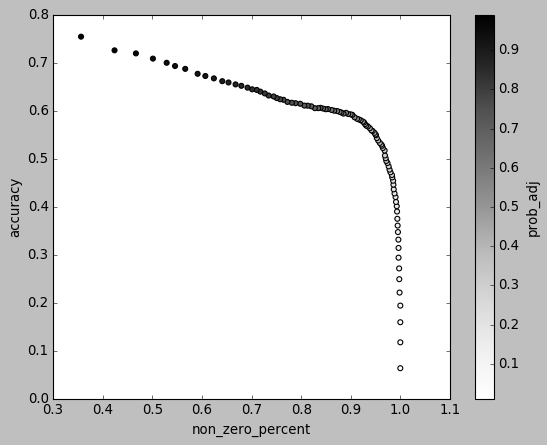

In [1188]:
p = results_tradeoff.plot.scatter(x = 'non_zero_percent',
                              y = 'accuracy',
                              c = 'prob_adj')

plt.show()

In [37]:
predictions = np.round(Y_pred_stack)

a = theme_results(Y_valid, predictions)
size = predictions.shape[0]
zero_size = (predictions[predictions.sum(axis = 1) == 0,:].shape[0])
print("Total comments:", size, 
      "\nTotal Predictions:", size - zero_size, 
      "\nPercent Pred non-zero:", round(1 - zero_size/size, 4))
a

NameError: name 'Y_pred_stack' is not defined

In [36]:
non_zero_pred = predictions[predictions.sum(axis = 1) != 0,:]
non_zero_valid = Y_valid[predictions.sum(axis = 1) != 0,:]

theme_results(non_zero_valid, non_zero_pred)

Overall Accuracy: 0.687 
Hamming Loss: 0.0404 
Hamming Loss (pred. zeros): 0.1142


,Label,Y_count,Pred_count,Error,Dummy_Diff,Accuarcy,Precision,Recall
0,CPD,195,158,0.048701,0.077922,0.951299,0.879747,0.712821
1,CB,437,384,0.042208,0.241558,0.957792,0.984375,0.864989
2,EWC,71,27,0.031169,0.014935,0.968831,0.925926,0.352113
3,Exec,61,33,0.022078,0.017532,0.977922,0.909091,0.491803
4,FWE,120,82,0.027273,0.050649,0.972727,0.975610,0.666667
5,SP,119,69,0.041558,0.035714,0.958442,0.898551,0.521008
6,RE,71,8,0.040909,0.005195,0.959091,1.000000,0.112676
7,Sup,116,80,0.033766,0.041558,0.966234,0.900000,0.620690
8,SW,242,150,0.081818,0.075325,0.918182,0.886667,0.549587
9,TEPE,546,524,0.055844,0.298701,0.944156,0.938931,0.901099
